## Libraries

In [3]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import numpy as np
import scipy
import datetime
import sys
import cv2
import os
sys.path.append("../../src")
from pix2pix_model import build_generator,build_discriminator
from glob import glob
from skimage import transform
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

## Load Functions

In [20]:
def load_data(batch_size=2, is_val=False):
        data_type = "train" if not is_val else "val"
        path = glob(f'../../data/LookBook-Labeled/{data_type}/*')        
        print(path) if len(path)==0 else None
        batch_images = np.random.choice(path, size=batch_size)

        imgs_A = []
        imgs_B = []
        for img_path in batch_images:
            img = (plt.imread(img_path)[...,:3]*255).astype(np.float)

            h, w, _ = img.shape
            _w = int(w/2)
            # because in the edges2shoes and maps dataset the input image comes before the ground truth.

            img_A, img_B = img[:, :_w, :], img[:, _w:, :]

            # If training => do random flip , this is a trick to avoid overfitting 
            if not is_val and np.random.random() < 0.5:
                img_A = np.fliplr(img_A)
                img_B = np.fliplr(img_B)

            imgs_A.append(img_A)
            imgs_B.append(img_B)
        #normalizing the images
        imgs_A = np.array(imgs_A)/127.5 - 1.  
        imgs_B = np.array(imgs_B)/127.5 - 1.

        return imgs_A, imgs_B

In [21]:
def load_batch( batch_size=2, is_val=False):
    data_type = "train" if not is_val else "val"
    path = glob(f'../../data/LookBook-Labeled/{data_type}/*')        
    n_batches=batch_size
    for i in range(n_batches-1):
        batch = path[i*batch_size:(i+1)*batch_size]
        imgs_A, imgs_B = [], []
        for img in batch:
            img = (plt.imread(img)[...,:3]*255).astype(np.float)
            h, w, _ = img.shape
            half_w = int(w/2)
            # because in the edges2shoes and maps dataset the input image comes before the ground truth.
            img_A, img_B = img[:, :half_w, :], img[:, half_w:, :]

            if not is_val and np.random.random() > 0.5:
                img_A = np.fliplr(img_A)
                img_B = np.fliplr(img_B)
            if not is_val and np.random.random() > 0.5:
                img_A = np.flipud(img_A)
                img_B = np.flipud(img_B)
            imgs_A.append(img_A)
            imgs_B.append(img_B)
        imgs_A = np.array(imgs_A)/127.5 - 1.
        imgs_B = np.array(imgs_B)/127.5 - 1.

        yield imgs_A, imgs_B

## Plot Function

In [22]:
def show_images(epoch,batch_size):
        
        r, c = 3, 3

        imgs_A, imgs_B = load_data(batch_size=3, is_val=True)
        fake_A = generator.predict(imgs_B)
        gen_imgs = np.concatenate([imgs_B, fake_A, imgs_A])
        gen_imgs = 0.5 * gen_imgs + 0.5
        titles = ['Input', 'Output', 'Ground Truth']
        fig, axs = plt.subplots(r, c,figsize=(10,10))
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt])
                axs[i, j].set_title(titles[i])
                axs[i,j].axis('off')
                cnt += 1
        
        plt.show()
        fig.savefig(f"epoch_{epoch}_batchsize_{batch_size}")
        plt.close()

## Training

In [23]:
img_rows = 256
img_cols = 256
channels = 3
img_shape = (img_rows, img_cols, channels)

# Calculate output shape of D (PatchGAN)
patch = int(img_rows / 2**4)
disc_patch = (patch, patch, 1)
gf = 64
df = 64
optimizer = Adam(0.0002, 0.5)

# Build and compile the discriminator
discriminator = build_discriminator()
discriminator.compile(loss='mse',
            optimizer=optimizer,
            metrics=['accuracy'])

# Build the generator
generator = build_generator()

# Input images and their conditioning images
img_A = Input(shape=img_shape)
img_B = Input(shape=img_shape)

# By conditioning on B generate a fake version of A
fake_A = generator(img_B)


# For the combined model we will only train the generator
discriminator.trainable = False

# Discriminators determines validity of translated images / condition pairs
valid = discriminator([fake_A, img_B])

combined = Model(inputs=[img_A, img_B], outputs=[valid, fake_A])
combined.compile(loss=['mse', 'mae'],
                              loss_weights=[1, 100],
                              optimizer=optimizer)


In [31]:
def train( epochs, batch_size=2, show_interval=10):

        start_time = datetime.datetime.now()

        # Adversarial loss ground truths
        valid = np.ones((batch_size,) + disc_patch)
        fake = np.zeros((batch_size,) + disc_patch)

        for epoch in range(epochs):
            print("Epoch :",epoch)
            for batch_i, (imgs_A, imgs_B) in enumerate(load_batch(batch_size)):
                print(batch_i,flush=True,end="\r")
            #  Train Discriminator
                # Condition on B and generate a translated version
                fake_A = generator.predict(imgs_B)

                # Train the discriminators (original images = real / generated = Fake)
                d_loss_real = discriminator.train_on_batch([imgs_A, imgs_B], valid)
                d_loss_fake = discriminator.train_on_batch([fake_A, imgs_B], fake)
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)            
                #  Train Generator
                g_loss = combined.train_on_batch([imgs_A, imgs_B], [valid, imgs_A])

                elapsed_time = datetime.datetime.now() - start_time

            print ("[Epoch %d/%d]  [D loss: %f, acc: %3d%%] [G loss: %f] time: %s" % (epoch, epochs,
                                                                        
                                                                        d_loss[0], 100*d_loss[1],
                                                                                      
                                                                        g_loss[0],
                                                                        elapsed_time))
            # If at show interval => show generated image samples
            if epoch % show_interval == 0:
                    show_images(epoch,batch_size)

In [32]:
# generator.load_weights("generator_rayas.h5")
# discriminator.load_weights("discriminator_rayas.h5")


Epoch : 0
[Epoch 0/2]  [D loss: 0.323190, acc:  51%] [G loss: 7.642192] time: 0:00:01.683008


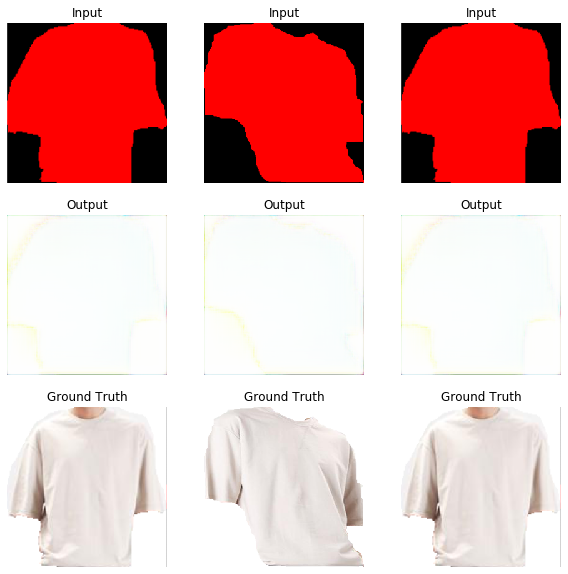

Epoch : 1
[Epoch 1/2]  [D loss: 0.314271, acc:  51%] [G loss: 6.904721] time: 0:00:04.091300


In [34]:
train(epochs=2,batch_size=4, show_interval=10)

In [ ]:
generator.save_weights(    "generator.h5")
discriminator.save_weights( "discriminator.h5")

